In [21]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import psutil

In [8]:
# 選擇股票
stocks = ['TLT', 'LQD', 'SMH', 'XLV', 'XLI', 'GLD']

# 從 Yahoo Finance 下載數據
data = yf.download(stocks, start='2000-01-01', end='2023-04-30')

# 選擇收盤價格
data = data['Adj Close']

# 計算收益率
returns = data.pct_change()

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq', 'fun': check_sum})
bounds = tuple((0, 1) for i in range(len(stocks)))
init_guess = len(stocks)*[1/len(stocks)]

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# 獲取最佳權重
optimal_weights = opt_results.x


[*********************100%***********************]  6 of 6 completed


In [9]:
# 計算夏普值並打印
optimal_portfolio = get_ret_vol_sr(optimal_weights)
print('Optimal weights:', optimal_weights)
print('Optimal portfolio:', optimal_portfolio)

# 繪製效率前緣曲線
frontier_y = np.linspace(0,0.3,100) 
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1] 

frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

Optimal weights: [2.00918973e-01 2.69304906e-01 5.04186002e-18 2.34057467e-01
 8.99920216e-02 2.05726632e-01]
Optimal portfolio: [0.07347485 0.08024672 0.91561192]


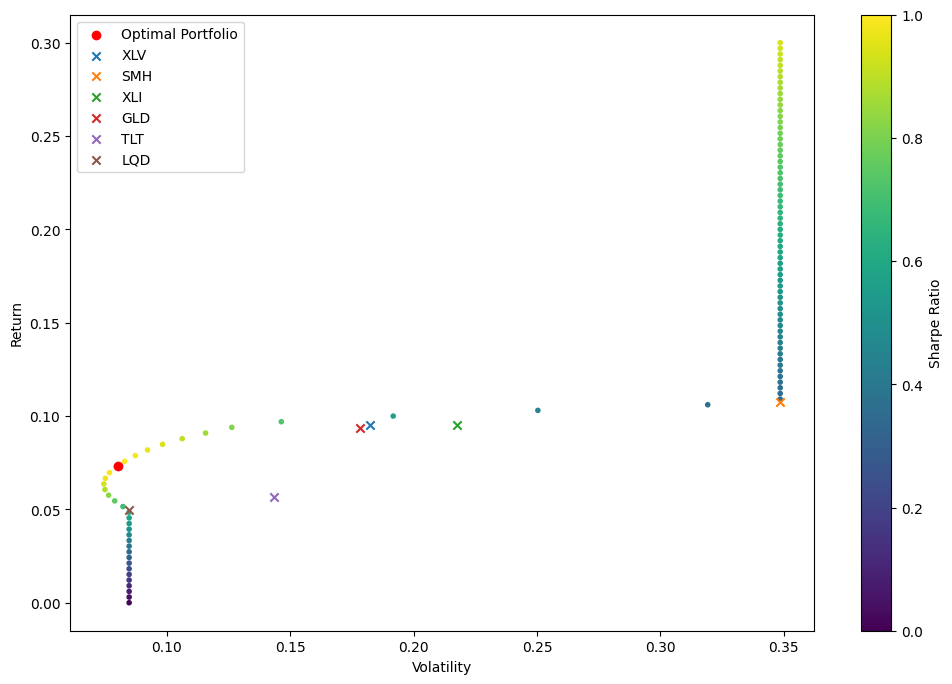

In [10]:
# 計算每個資產的預期回報和波動性
expected_returns = returns.mean() * 252
volatilities = returns.std() * np.sqrt(252)

plt.figure(figsize=(12,8))
plt.scatter(frontier_volatility, frontier_y, c=(frontier_y)/frontier_volatility, marker='.')
plt.scatter(optimal_portfolio[1], optimal_portfolio[0], color='r', label='Optimal Portfolio')

# 添加每個資產到圖中
for asset in ['XLV', 'SMH', 'XLI', 'GLD', 'TLT', 'LQD']:
    plt.scatter(volatilities[asset], expected_returns[asset], marker='x', label=asset)

plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()


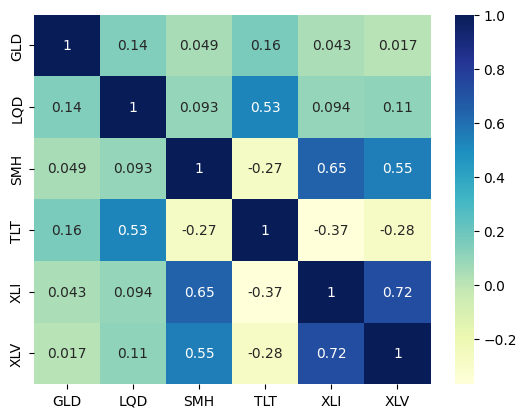

In [11]:
# 繪製熱力圖
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

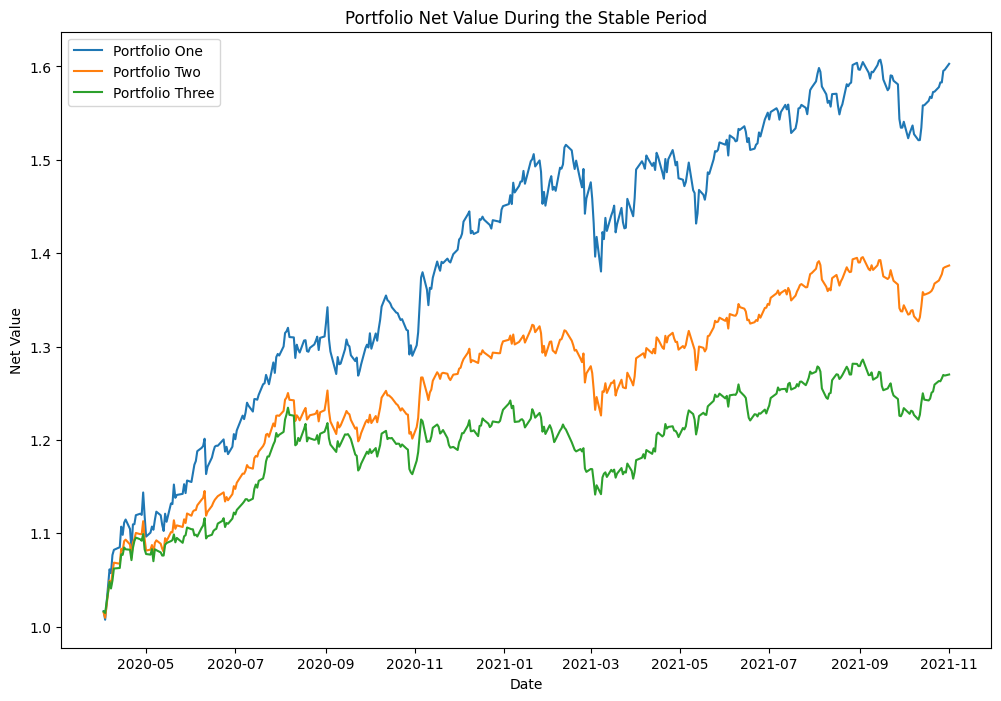

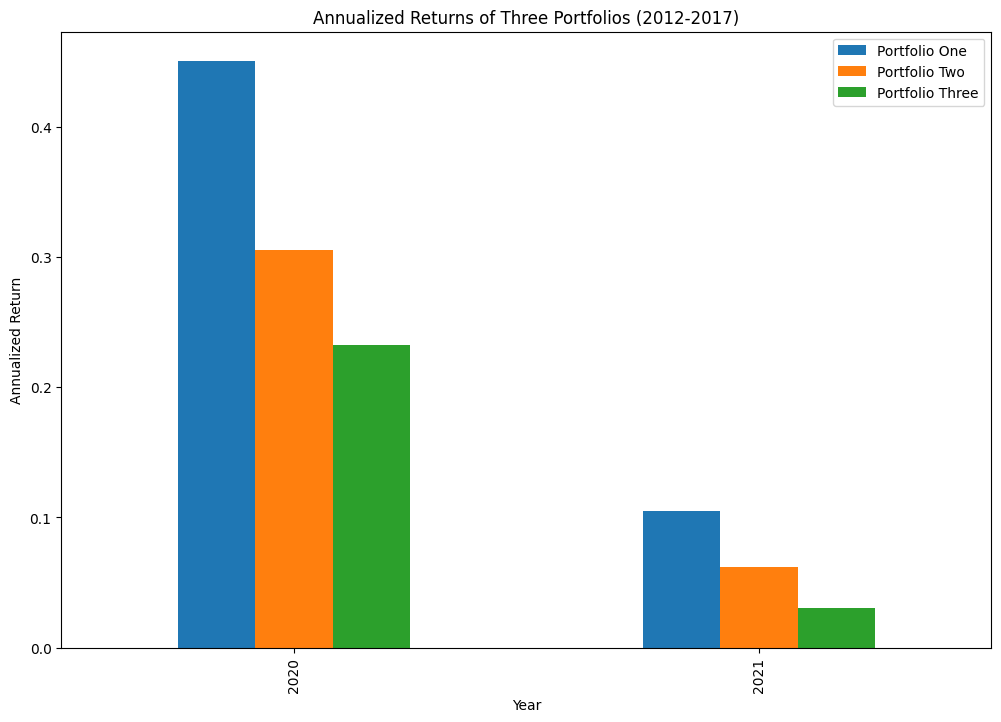

In [12]:
portfolio_weights_one = [0.15, 0.2, 0.4, 0.15, 0.05, 0.05]
portfolio_weights_two = [0.2, 0.15, 0.2, 0.25, 0.08, 0.12]
portfolio_weights_three = [0.4, 0.0, 0.05, 0.25, 0.1, 0.2]

# 選擇成長期
stable_period_growth = data[(data.index >= '2020-04-01') & (data.index <= '2021-11-01')]
stable_returns_growth = stable_period_growth.pct_change()

# 計算穩健期的投資組合淨值
stable_net_value_one = (1 + stable_returns_growth.dot(portfolio_weights_one)).cumprod()
stable_net_value_two = (1 + stable_returns_growth.dot(portfolio_weights_two)).cumprod()
stable_net_value_three = (1 + stable_returns_growth.dot(portfolio_weights_three)).cumprod()

# 繪製圖表
plt.figure(figsize=(12,8))
plt.plot(stable_net_value_one, label='Portfolio One')
plt.plot(stable_net_value_two, label='Portfolio Two')
plt.plot(stable_net_value_three, label='Portfolio Three')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.title('Portfolio Net Value During the Stable Period')
plt.legend(loc='upper left')
plt.show()

# 計算每個投資組合每年的年化收益
annual_returns_one = stable_returns_growth.dot(portfolio_weights_one).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_two = stable_returns_growth.dot(portfolio_weights_two).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_three = stable_returns_growth.dot(portfolio_weights_three).resample('Y').apply(lambda x: (1 + x).prod() - 1)

# 將年份格式從 yyyy-mm-dd 轉換為 yyyy
annual_returns_one.index = annual_returns_one.index.strftime('%Y')
annual_returns_two.index = annual_returns_two.index.strftime('%Y')
annual_returns_three.index = annual_returns_three.index.strftime('%Y')

# 將結果儲存在一個 DataFrame
annual_returns = pd.DataFrame({
    'Portfolio One': annual_returns_one,
    'Portfolio Two': annual_returns_two,
    'Portfolio Three': annual_returns_three
})

# 繪製 bar chart
annual_returns.plot(kind='bar', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.title('Annualized Returns of Three Portfolios (2012-2017)')
plt.show()

In [13]:
print('Portfolio_one :')

# 計算年化報酬率
annual_return_one = stable_returns_growth.dot(portfolio_weights_one).mean() * 252
print('Annualized Return for Portfolio One:', annual_return_one)

# 計算標準差
std_dev_one = stable_returns_growth.dot(portfolio_weights_one).std() * np.sqrt(252)
print('Standard Deviation for Portfolio One:', std_dev_one)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_one = (annual_return_one - rf_rate) / std_dev_one
print('Sharpe Ratio for Portfolio One:', sharpe_ratio_one)

# 計算最大回檔和最大回檔回復時間
cum_returns_one = stable_returns_growth.dot(portfolio_weights_one).add(1).cumprod()
peak = cum_returns_one.cummax()
drawdown = (cum_returns_one - peak) / peak
max_drawdown = drawdown.min()
print('Max Drawdown for Portfolio One:', max_drawdown)

print('-----------------------------------------------------------------------------')

print('Portfolio_two :')

# 計算年化報酬率
annual_return_two = stable_returns_growth.dot(portfolio_weights_two).mean() * 252
print('Annualized Return for Portfolio Two:', annual_return_two)

# 計算標準差
std_dev_two = stable_returns_growth.dot(portfolio_weights_two).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Two:', std_dev_two)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_two = (annual_return_two - rf_rate) / std_dev_two
print('Sharpe Ratio for Portfolio Two:', sharpe_ratio_two)

# 計算最大回檔和最大回檔回復時間
cum_returns_two = stable_returns_growth.dot(portfolio_weights_two).add(1).cumprod()
peak_two = cum_returns_two.cummax()
drawdown_two = (cum_returns_two - peak_two) / peak_two
max_drawdown_two = drawdown_two.min()
print('Max Drawdown for Portfolio Two:', max_drawdown_two)

print('-----------------------------------------------------------------------------')

print('Portfolio_three :')

# 計算年化報酬率
annual_return_three = stable_returns_growth.dot(portfolio_weights_three).mean() * 252
print('Annualized Return for Portfolio Three:', annual_return_three)

# 計算標準差
std_dev_three = stable_returns_growth.dot(portfolio_weights_three).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Three:', std_dev_three)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_three = (annual_return_three - rf_rate) / std_dev_three
print('Sharpe Ratio for Portfolio Three:', sharpe_ratio_three)

# 計算最大回檔和最大回檔回復時間
cum_returns_three = stable_returns_growth.dot(portfolio_weights_three).add(1).cumprod()
peak_three = cum_returns_three.cummax()
drawdown_three = (cum_returns_three - peak_three) / peak_three
max_drawdown_three = drawdown_three.min()
print('Max Drawdown for Portfolio Three:', max_drawdown_three)


Portfolio_one :
Annualized Return for Portfolio One: 0.3085933246231326
Standard Deviation for Portfolio One: 0.14997281796530268
Sharpe Ratio for Portfolio One: 1.9243042075124626
Max Drawdown for Portfolio One: -0.08949613009546016
-----------------------------------------------------------------------------
Portfolio_two :
Annualized Return for Portfolio Two: 0.21192693629026058
Standard Deviation for Portfolio Two: 0.10789751468037553
Sharpe Ratio for Portfolio Two: 1.778789222891789
Max Drawdown for Portfolio Two: -0.07339462653142595
-----------------------------------------------------------------------------
Portfolio_three :
Annualized Return for Portfolio Three: 0.15557678731791796
Standard Deviation for Portfolio Three: 0.09894649327316812
Sharpe Ratio for Portfolio Three: 1.3702030545299082
Max Drawdown for Portfolio Three: -0.08107819497705697


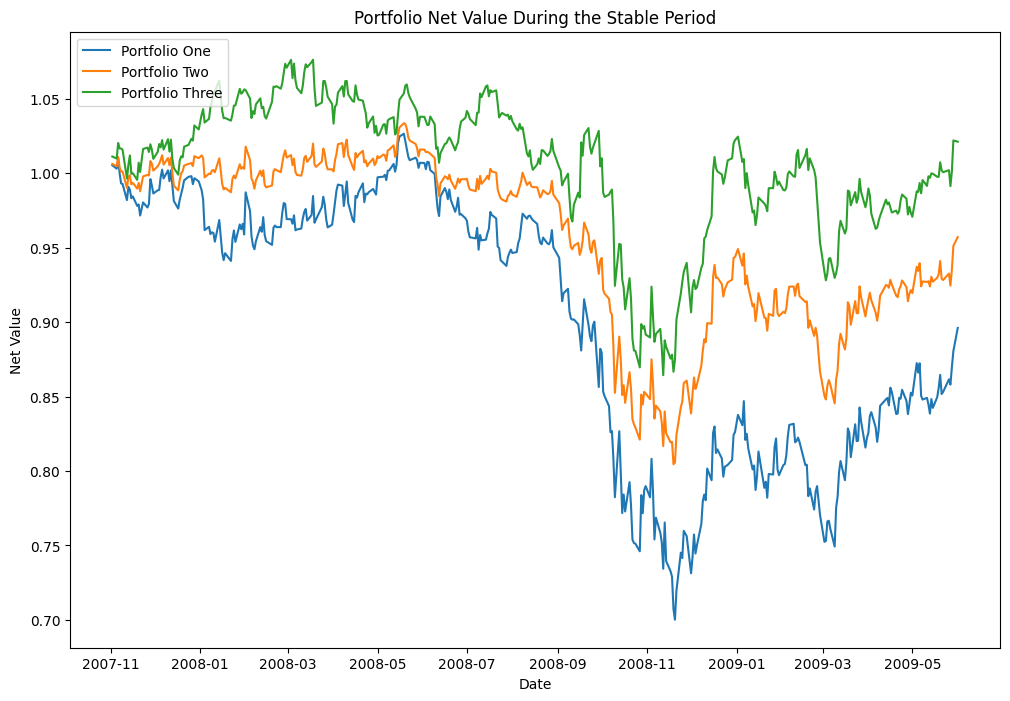

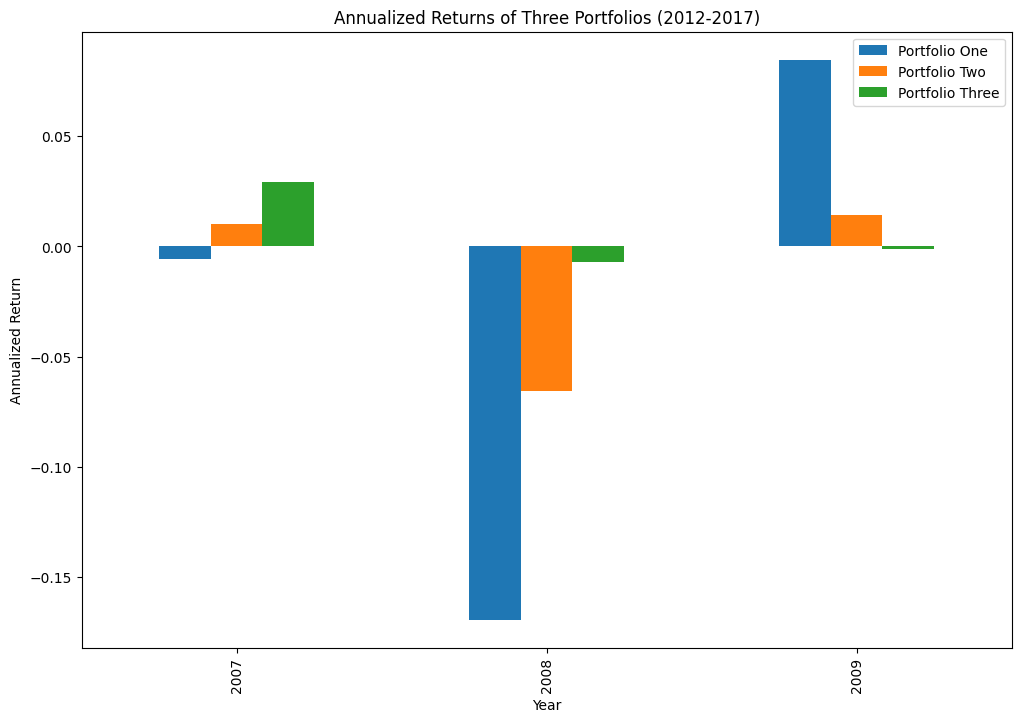

In [14]:
# 選擇衰退期
stable_period_recession = data[(data.index >= '2007-11-01') & (data.index <= '2009-06-01')]
stable_returns_recession = stable_period_recession.pct_change()

# 計算穩健期的投資組合淨值
stable_net_value_one = (1 + stable_returns_recession.dot(portfolio_weights_one)).cumprod()
stable_net_value_two = (1 + stable_returns_recession.dot(portfolio_weights_two)).cumprod()
stable_net_value_three = (1 + stable_returns_recession.dot(portfolio_weights_three)).cumprod()

# 繪製圖表
plt.figure(figsize=(12,8))
plt.plot(stable_net_value_one, label='Portfolio One')
plt.plot(stable_net_value_two, label='Portfolio Two')
plt.plot(stable_net_value_three, label='Portfolio Three')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.title('Portfolio Net Value During the Stable Period')
plt.legend(loc='upper left')
plt.show()

# 計算每個投資組合每年的年化收益
annual_returns_one = stable_returns_recession.dot(portfolio_weights_one).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_two = stable_returns_recession.dot(portfolio_weights_two).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_three = stable_returns_recession.dot(portfolio_weights_three).resample('Y').apply(lambda x: (1 + x).prod() - 1)

# 將年份格式從 yyyy-mm-dd 轉換為 yyyy
annual_returns_one.index = annual_returns_one.index.strftime('%Y')
annual_returns_two.index = annual_returns_two.index.strftime('%Y')
annual_returns_three.index = annual_returns_three.index.strftime('%Y')

# 將結果儲存在一個 DataFrame
annual_returns = pd.DataFrame({
    'Portfolio One': annual_returns_one,
    'Portfolio Two': annual_returns_two,
    'Portfolio Three': annual_returns_three
})

# 繪製 bar chart
annual_returns.plot(kind='bar', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.title('Annualized Returns of Three Portfolios (2012-2017)')
plt.show()

In [15]:
# 選擇衰退期
stable_period_recession = data[(data.index >= '2007-11-01') & (data.index <= '2009-06-01')]
stable_returns_recession = stable_period_recession.pct_change()

print('Portfolio_one :')

# 計算年化報酬率
annual_return_one = stable_returns_recession.dot(portfolio_weights_one).mean() * 252
print('Annualized Return for Portfolio One:', annual_return_one)

# 計算標準差
std_dev_one = stable_returns_recession.dot(portfolio_weights_one).std() * np.sqrt(252)
print('Standard Deviation for Portfolio One:', std_dev_one)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_one = (annual_return_one - rf_rate) / std_dev_one
print('Sharpe Ratio for Portfolio One:', sharpe_ratio_one)

# 計算最大回檔和最大回檔回復時間
cum_returns_one = stable_returns_recession.dot(portfolio_weights_one).add(1).cumprod()
peak = cum_returns_one.cummax()
drawdown = (cum_returns_one - peak) / peak
max_drawdown = drawdown.min()
print('Max Drawdown for Portfolio One:', max_drawdown)

print('-----------------------------------------------------------------------------')

print('Portfolio_two :')

# 計算年化報酬率
annual_return_two = stable_returns_recession.dot(portfolio_weights_two).mean() * 252
print('Annualized Return for Portfolio Two:', annual_return_two)

# 計算標準差
std_dev_two = stable_returns_recession.dot(portfolio_weights_two).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Two:', std_dev_two)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_two = (annual_return_two - rf_rate) / std_dev_two
print('Sharpe Ratio for Portfolio Two:', sharpe_ratio_two)

# 計算最大回檔和最大回檔回復時間
cum_returns_two = stable_returns_recession.dot(portfolio_weights_two).add(1).cumprod()
peak_two = cum_returns_two.cummax()
drawdown_two = (cum_returns_two - peak_two) / peak_two
max_drawdown_two = drawdown_two.min()
print('Max Drawdown for Portfolio Two:', max_drawdown_two)

print('-----------------------------------------------------------------------------')

print('Portfolio_three :')

# 計算年化報酬率
annual_return_three = stable_returns_recession.dot(portfolio_weights_three).mean() * 252
print('Annualized Return for Portfolio Three:', annual_return_three)

# 計算標準差
std_dev_three = stable_returns_recession.dot(portfolio_weights_three).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Three:', std_dev_three)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_three = (annual_return_three - rf_rate) / std_dev_three
print('Sharpe Ratio for Portfolio Three:', sharpe_ratio_three)

# 計算最大回檔和最大回檔回復時間
cum_returns_three = stable_returns_recession.dot(portfolio_weights_three).add(1).cumprod()
peak_three = cum_returns_three.cummax()
drawdown_three = (cum_returns_three - peak_three) / peak_three
max_drawdown_three = drawdown_three.min()
print('Max Drawdown for Portfolio Three:', max_drawdown_three)


Portfolio_one :
Annualized Return for Portfolio One: -0.047586657527406775
Standard Deviation for Portfolio One: 0.21129711586299182
Sharpe Ratio for Portfolio One: -0.31986549958983335
Max Drawdown for Portfolio One: -0.31794601318791127
-----------------------------------------------------------------------------
Portfolio_two :
Annualized Return for Portfolio Two: -0.016701151868148852
Standard Deviation for Portfolio Two: 0.15022173322848906
Sharpe Ratio for Portfolio Two: -0.2443131967617892
Max Drawdown for Portfolio Two: -0.22159670890157102
-----------------------------------------------------------------------------
Portfolio_three :
Annualized Return for Portfolio Three: 0.025305613592512762
Standard Deviation for Portfolio Three: 0.15523820149853781
Sharpe Ratio for Portfolio Three: 0.03417724207892692
Max Drawdown for Portfolio Three: -0.19684527495640722


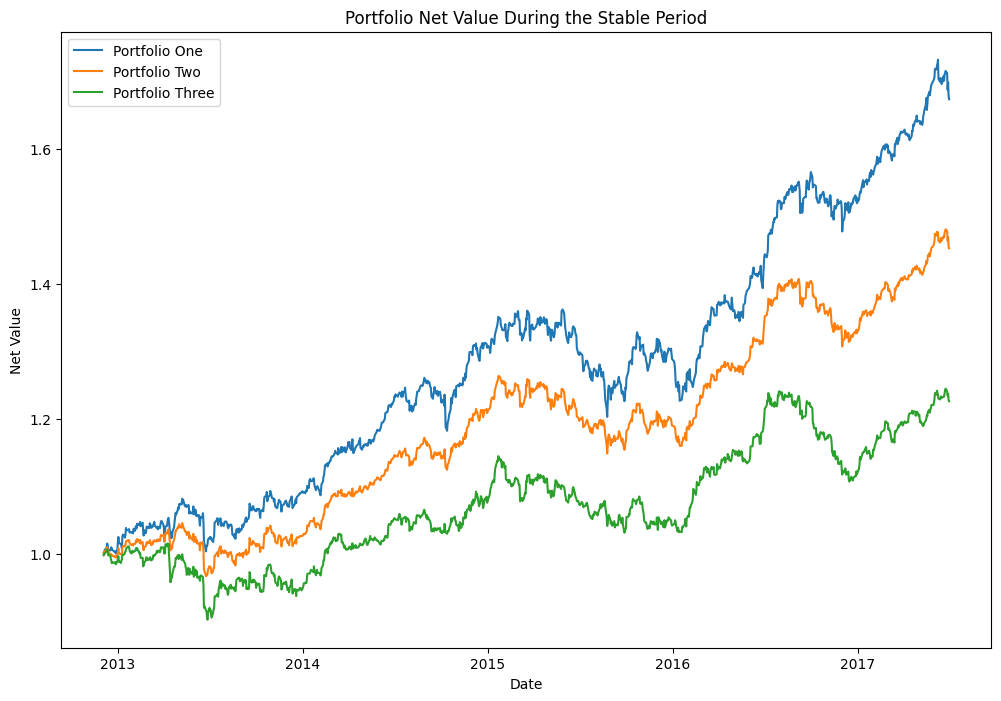

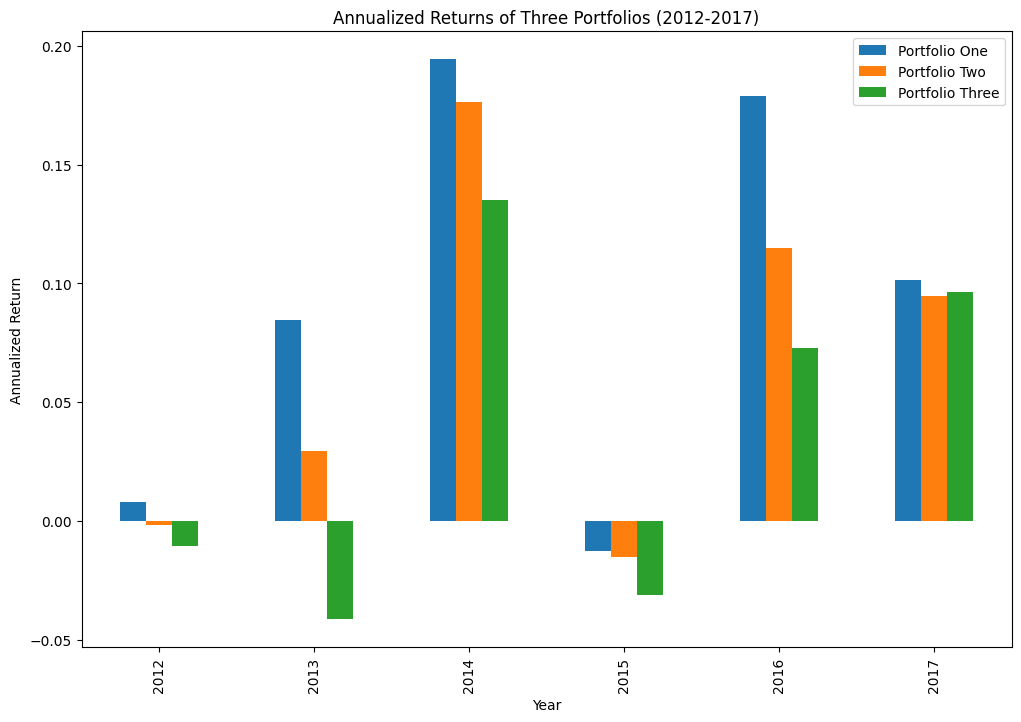

In [16]:
# 選擇穩健期
stable_period_stable = data[(data.index >= '2012-12-01') & (data.index <= '2017-06-30')]
stable_returns_stable = stable_period_stable.pct_change()

# 計算穩健期的投資組合淨值
stable_net_value_one = (1 + stable_returns_stable.dot(portfolio_weights_one)).cumprod()
stable_net_value_two = (1 + stable_returns_stable.dot(portfolio_weights_two)).cumprod()
stable_net_value_three = (1 + stable_returns_stable.dot(portfolio_weights_three)).cumprod()

# 繪製圖表
plt.figure(figsize=(12,8))
plt.plot(stable_net_value_one, label='Portfolio One')
plt.plot(stable_net_value_two, label='Portfolio Two')
plt.plot(stable_net_value_three, label='Portfolio Three')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.title('Portfolio Net Value During the Stable Period')
plt.legend(loc='upper left')
plt.show()

# 計算每個投資組合每年的年化收益
annual_returns_one = stable_returns_stable.dot(portfolio_weights_one).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_two = stable_returns_stable.dot(portfolio_weights_two).resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns_three = stable_returns_stable.dot(portfolio_weights_three).resample('Y').apply(lambda x: (1 + x).prod() - 1)

# 將年份格式從 yyyy-mm-dd 轉換為 yyyy
annual_returns_one.index = annual_returns_one.index.strftime('%Y')
annual_returns_two.index = annual_returns_two.index.strftime('%Y')
annual_returns_three.index = annual_returns_three.index.strftime('%Y')

# 將結果儲存在一個 DataFrame
annual_returns = pd.DataFrame({
    'Portfolio One': annual_returns_one,
    'Portfolio Two': annual_returns_two,
    'Portfolio Three': annual_returns_three
})

# 繪製 bar chart
annual_returns.plot(kind='bar', figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Annualized Return')
plt.title('Annualized Returns of Three Portfolios (2012-2017)')
plt.show()

In [17]:
# 選擇穩定期
stable_period_stable = data[(data.index >= '2010-01-01') & (data.index <= '2011-12-31')]
stable_returns_stable = stable_period_stable.pct_change()

print('Portfolio_one :')

# 計算年化報酬率
annual_return_one = stable_returns_stable.dot(portfolio_weights_one).mean() * 252
print('Annualized Return for Portfolio One:', annual_return_one)

# 計算標準差
std_dev_one = stable_returns_stable.dot(portfolio_weights_one).std() * np.sqrt(252)
print('Standard Deviation for Portfolio One:', std_dev_one)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_one = (annual_return_one - rf_rate) / std_dev_one
print('Sharpe Ratio for Portfolio One:', sharpe_ratio_one)

# 計算最大回檔和最大回檔回復時間
cum_returns_one = stable_returns_stable.dot(portfolio_weights_one).add(1).cumprod()
peak = cum_returns_one.cummax()
drawdown = (cum_returns_one - peak) / peak
max_drawdown = drawdown.min()
print('Max Drawdown for Portfolio One:', max_drawdown)

print('-----------------------------------------------------------------------------')

print('Portfolio_two :')

# 計算年化報酬率
annual_return_two = stable_returns_stable.dot(portfolio_weights_two).mean() * 252
print('Annualized Return for Portfolio Two:', annual_return_two)

# 計算標準差
std_dev_two = stable_returns_stable.dot(portfolio_weights_two).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Two:', std_dev_two)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_two = (annual_return_two - rf_rate) / std_dev_two
print('Sharpe Ratio for Portfolio Two:', sharpe_ratio_two)

# 計算最大回檔和最大回檔回復時間
cum_returns_two = stable_returns_stable.dot(portfolio_weights_two).add(1).cumprod()
peak_two = cum_returns_two.cummax()
drawdown_two = (cum_returns_two - peak_two) / peak_two
max_drawdown_two = drawdown_two.min()
print('Max Drawdown for Portfolio Two:', max_drawdown_two)

print('-----------------------------------------------------------------------------')

print('Portfolio_three :')

# 計算年化報酬率
annual_return_three = stable_returns_stable.dot(portfolio_weights_three).mean() * 252
print('Annualized Return for Portfolio Three:', annual_return_three)

# 計算標準差
std_dev_three = stable_returns_stable.dot(portfolio_weights_three).std() * np.sqrt(252)
print('Standard Deviation for Portfolio Three:', std_dev_three)

# 計算夏普值
rf_rate = 0.02  # 假設無風險利率為2%
sharpe_ratio_three = (annual_return_three - rf_rate) / std_dev_three
print('Sharpe Ratio for Portfolio Three:', sharpe_ratio_three)

# 計算最大回檔和最大回檔回復時間
cum_returns_three = stable_returns_stable.dot(portfolio_weights_three).add(1).cumprod()
peak_three = cum_returns_three.cummax()
drawdown_three = (cum_returns_three - peak_three) / peak_three
max_drawdown_three = drawdown_three.min()
print('Max Drawdown for Portfolio Three:', max_drawdown_three)


Portfolio_one :
Annualized Return for Portfolio One: 0.11548000702005587
Standard Deviation for Portfolio One: 0.11915363917495116
Sharpe Ratio for Portfolio One: 0.8013184295602107
Max Drawdown for Portfolio One: -0.07909530012196135
-----------------------------------------------------------------------------
Portfolio_two :
Annualized Return for Portfolio Two: 0.1363919407089512
Standard Deviation for Portfolio Two: 0.08723791223778139
Sharpe Ratio for Portfolio Two: 1.3341898920243032
Max Drawdown for Portfolio Two: -0.04793872660258601
-----------------------------------------------------------------------------
Portfolio_three :
Annualized Return for Portfolio Three: 0.15754960663113518
Standard Deviation for Portfolio Three: 0.09747066430100215
Sharpe Ratio for Portfolio Three: 1.4111897935399724
Max Drawdown for Portfolio Three: -0.054435942097517016


In [18]:
sample_period = data[(data.index >= '2005-01-01') & (data.index <= '2022-12-31')]
returns = sample_period.pct_change()

# Portfolio 1
annual_return_one = returns.dot(portfolio_weights_one).mean() * 252
annual_std_dev_one = returns.dot(portfolio_weights_one).std() * np.sqrt(252)

# Portfolio 2
annual_return_two = returns.dot(portfolio_weights_two).mean() * 252
annual_std_dev_two = returns.dot(portfolio_weights_two).std() * np.sqrt(252)

# Portfolio 3
annual_return_three = returns.dot(portfolio_weights_three).mean() * 252
annual_std_dev_three = returns.dot(portfolio_weights_three).std() * np.sqrt(252)

n_simulations = 10000
n_trading_days = 252
n_years = 5

def simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return, annual_std_dev):
    final_returns = []
    max_drawdowns = []
    for _ in range(n_simulations):
        daily_returns = np.random.normal(annual_return/n_trading_days, annual_std_dev/np.sqrt(n_trading_days), n_trading_days*n_years) + 1
        price_path = np.cumprod(daily_returns)
        peak = np.maximum.accumulate(price_path)
        drawdown = (price_path - peak) / peak
        max_drawdown = drawdown.min()
        final_return = price_path[-1]

        final_returns.append(final_return)
        max_drawdowns.append(max_drawdown)
        
    return final_returns, max_drawdowns

final_returns_one, max_drawdowns_one = simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return_one, annual_std_dev_one)
final_returns_two, max_drawdowns_two = simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return_two, annual_std_dev_two)
final_returns_three, max_drawdowns_three = simulate_portfolio(n_simulations, n_trading_days, n_years, annual_return_three, annual_std_dev_three)

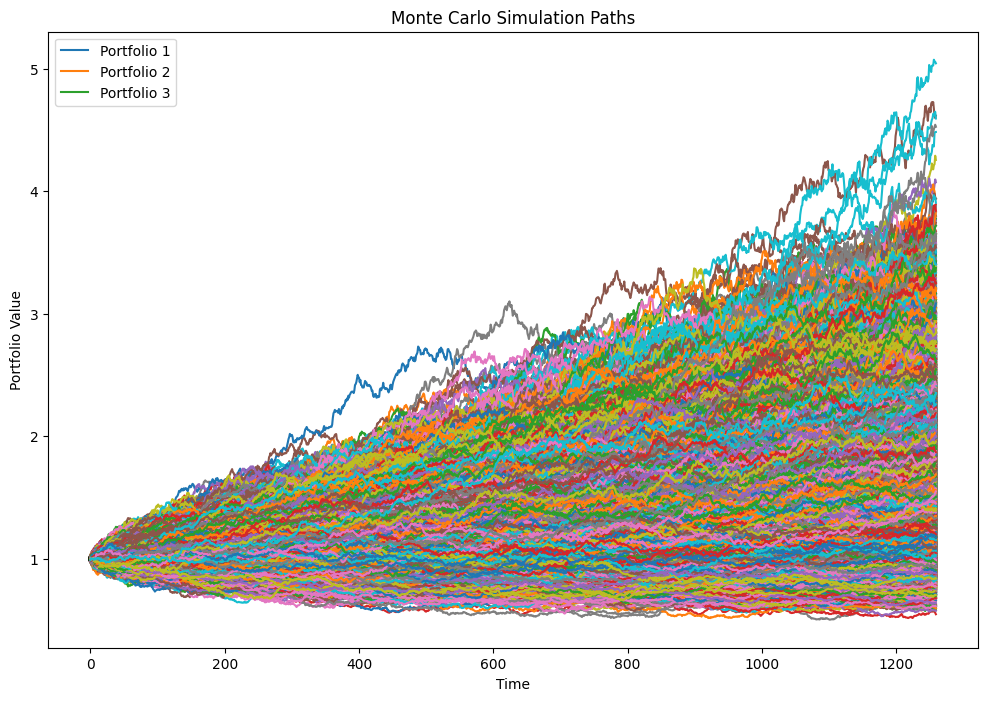

In [19]:
plt.figure(figsize=(12, 8))

# Portfolio 1
for i in range(n_simulations):
    daily_returns = np.random.normal(annual_return_one / n_trading_days, annual_std_dev_one / np.sqrt(n_trading_days), n_trading_days * n_years) + 1
    price_path = np.cumprod(daily_returns)
    plt.plot(price_path)

# Portfolio 2
for i in range(n_simulations):
    daily_returns = np.random.normal(annual_return_two / n_trading_days, annual_std_dev_two / np.sqrt(n_trading_days), n_trading_days * n_years) + 1
    price_path = np.cumprod(daily_returns)
    plt.plot(price_path)

# Portfolio 3
for i in range(n_simulations):
    daily_returns = np.random.normal(annual_return_three / n_trading_days, annual_std_dev_three / np.sqrt(n_trading_days), n_trading_days * n_years) + 1
    price_path = np.cumprod(daily_returns)
    plt.plot(price_path)

plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Monte Carlo Simulation Paths')
plt.legend(['Portfolio 1', 'Portfolio 2', 'Portfolio 3'])
plt.show()


In [22]:
# 獲取CPU使用率
cpu_usage = psutil.cpu_percent(interval=1)

# 獲取記憶體使用情況
memory = psutil.virtual_memory()
total_memory = round(memory.total / (1024 ** 3), 2)  # 總記憶體（GB）
available_memory = round(memory.available / (1024 ** 3), 2)  # 可用記憶體（GB）

# 獲取硬碟使用情況
disk_usage = psutil.disk_usage('/')
total_disk_space = round(disk_usage.total / (1024 ** 3), 2)  # 總硬碟空間（GB）
used_disk_space = round(disk_usage.used / (1024 ** 3), 2)  # 已使用硬碟空間（GB）

# 獲取網路使用情況
network = psutil.net_io_counters()
sent_bytes = round(network.bytes_sent / (1024 ** 2), 2)  # 已發送數據量（MB）
received_bytes = round(network.bytes_recv / (1024 ** 2), 2)  # 已接收數據量（MB）

# 輸出性能表
print('CPU Usage:', cpu_usage, '%')
print('Total Memory:', total_memory, 'GB')
print('Available Memory:', available_memory, 'GB')
print('Total Disk Space:', total_disk_space, 'GB')
print('Used Disk Space:', used_disk_space, 'GB')
print('Sent Bytes:', sent_bytes, 'MB')
print('Received Bytes:', received_bytes, 'MB')

CPU Usage: 15.6 %
Total Memory: 8.0 GB
Available Memory: 1.55 GB
Total Disk Space: 228.27 GB
Used Disk Space: 8.46 GB
Sent Bytes: 319.48 MB
Received Bytes: 14088.71 MB
